In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb


In [53]:
train=pd.read_csv('train.csv', na_values=-1)
test=pd.read_csv('test.csv', na_values=-1)


In [54]:
train.isnull().values.any()

True

In [55]:
features = train.drop(['id','target'], axis=1).values
targets = train.target.values

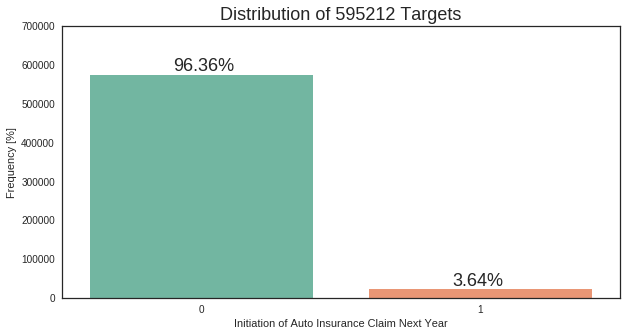

In [56]:
ax = sns.countplot(x = targets ,palette="Set2")
sns.set(font_scale=1.5)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=700000)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(targets)), (p.get_x()+ 0.3, p.get_height()+10000))

plt.title('Distribution of 595212 Targets')
plt.xlabel('Initiation of Auto Insurance Claim Next Year')
plt.ylabel('Frequency [%]')
plt.show()


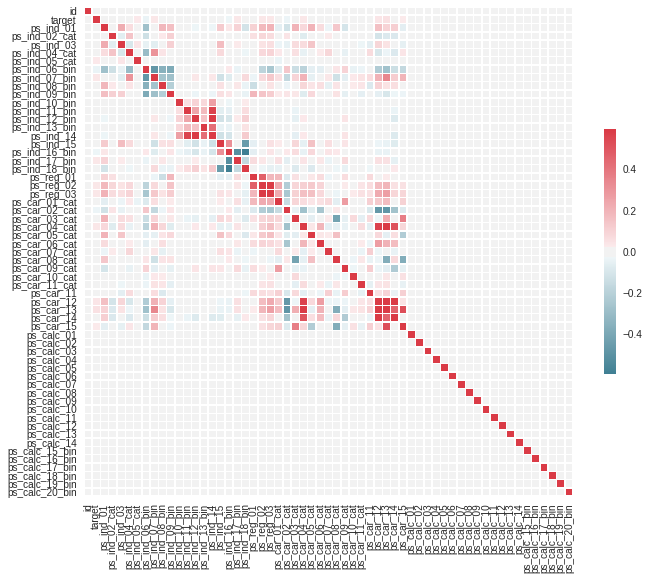

In [57]:
sns.set(style="white")


# Compute the correlation matrix
corr = train.corr()


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [58]:
# Define the gini metric - from https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703#5897
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

In [59]:
unwanted = train.columns[train.columns.str.startswith('ps_calc_')]

In [60]:
train = train.drop(unwanted, axis=1)  
test = test.drop(unwanted, axis=1)  

In [61]:
kfold = 5
skf = StratifiedKFold(n_splits=kfold, random_state=42)

In [62]:
params = {
    'min_child_weight': 10.0,
    'objective': 'binary:logistic',
    'max_depth': 7,
    'max_delta_step': 1.8,
    'colsample_bytree': 0.4,
    'subsample': 0.9,
    'eta': 0.03,
    'gamma': 0.65,
    'num_boost_round' : 700
    }

In [63]:
X = train.drop(['id', 'target'], axis=1).values
y = train.target.values
test_id = test.id.values
test = test.drop('id', axis=1)


In [64]:
sub = pd.DataFrame()
sub['id'] = test_id
sub['target'] = np.zeros_like(test_id)


In [65]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    # Convert our data into XGBoost format
    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    d_test = xgb.DMatrix(test.values)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    # Train the model! We pass in a max of 1,600 rounds (with early stopping after 70)
    # and the custom metric (maximize=True tells xgb that higher metric is better)
    mdl = xgb.train(params, d_train, 1600, watchlist, early_stopping_rounds=70, feval=gini_xgb, maximize=True, verbose_eval=100)

    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    # Predict on our test data
    p_test = mdl.predict(d_test)
    sub['target'] += p_test/kfold

[Fold 1/5]
[0]	train-gini:0.055512	valid-gini:0.056025
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
[100]	train-gini:0.32917	valid-gini:0.266141
[200]	train-gini:0.379376	valid-gini:0.276949
[300]	train-gini:0.416707	valid-gini:0.280202
[400]	train-gini:0.444771	valid-gini:0.281249
Stopping. Best iteration:
[335]	train-gini:0.428332	valid-gini:0.28165

[Fold 1/5 Prediciton:]
[Fold 2/5]
[0]	train-gini:0.023175	valid-gini:0.036338
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
[100]	train-gini:0.327713	valid-gini:0.2682
[200]	train-gini:0.377426	valid-gini:0.280889
[300]	train-gini:0.41772	valid-gini:0.286998
[400]	train-gini:0.444848	valid-gini:0.288472
[500]	train-gini:0.468256	valid-gini:0.288138
Stopping. Best iteration:
[468]	train-gini:0.461311	valid-gini:0.288762

[Fold 2/5 Prediciton:]

In [66]:
sub.to_csv('StratifiedKFold.csv', index=False)